Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов


In [1]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Возможно ниже будет не очень работать WandbLogger с первого разу, перезапустите kernel тетрадки
import wandb

wandb.login()

wandb.init(project="lightning_logs", entity="nikoz")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikoz. Use `wandb login --relogin` to force relogin


In [2]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torchvision.transforms import Compose, Normalize, ToPILImage, ToTensor, RandomHorizontalFlip, Resize, ColorJitter,  RandomRotation
from torchvision.models import resnet18, vit_b_16, resnet50
# You may add any imports you need

In [3]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [4]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-11-01 18:30:52--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-11-01 18:30:52--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc309041503a22e5c929b4812b4c.dl.dropboxusercontent.com/cd/0/get/Bv_peHDkPYLvnQyVNC7ZeVEGTS0LgodHU2IYSHt240BjkE1GzFEEu3yw26nzqKaaV0Pkygv01AnLqeKiC_5WnDab41_0NN6-voTVw5jGMspy0cg3aD9K3DYzPT7kxrzOMDBNJlhIK71F6uj_WVf6j_XN9U7pryu8P3b_xHQfZ5TBrA/file?dl=1# [following]
--2022-11-01 18:30:53--  https://uc309041503a22e5c929b4812b4c.dl.dropboxusercontent.com/cd/0/get/Bv_peHDkPYLvnQyVNC7ZeVEGTS0LgodHU2IYSHt240BjkE1GzFEEu3yw26nzqKaaV0Pkygv01AnLqe

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [4]:
# YOU CAN DEFINE AUGMENTATIONS HERE
import PIL

train_transform = Compose(
        [ 
            #transforms.ColorJitter(hue=.05, saturation=.05),
            transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
            ToTensor(), 
            Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)),
            #Normalize((0.5, 0.5, 0.5), (1, 1, 1)) 
        ]
    )
val_transform = Compose(
        [ 
            ToTensor(), 
            Normalize((0.4459, 0.4148, 0.3672), (0.2444, 0.2368, 0.2305)),
            #Normalize((0.5, 0.5, 0.5), (1, 1, 1))  
        ]
    )

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4) # YOUR CODE HERE
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4) # YOUR CODE HERE

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
means_train = []
vars_train = []
for image, label in train_dataset:
    means_train.append(image.mean(dim=(1,2)))
    vars_train.append(image.std(dim=(1,2)))

torch.stack(means_train).mean(dim=0), torch.stack(vars_train).mean(dim=0)

(tensor([0.4802, 0.4481, 0.3975]), tensor([0.2302, 0.2265, 0.2262]))

In [ ]:
means_val = []
vars_val = []
for image, label in val_dataset:
    means_val.append(image.mean(dim=(1,2)))
    vars_val.append(image.std(dim=(1,2)))

torch.stack(means_val).mean(dim=0), torch.stack(vars_val).mean(dim=0)

(tensor([-1.5475e-04,  9.6333e-06,  1.1633e-04]),
 tensor([1.0001, 0.9998, 1.0000]))

In [5]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

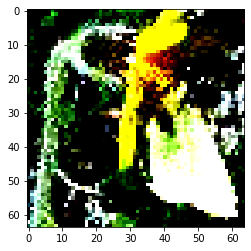

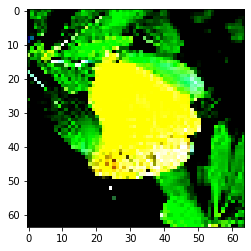

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [ ]:
resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Тренировочный класс lightning

In [6]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        # YOUR CODE HERE
        self.model = model
        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()
        #pass

    def forward(self, x) -> torch.Tensor:
        # YOUR CODE HERE
        preds = self.model(x)
        return preds
        #pass

    def configure_optimizers(self):
        # YOUR CODE HERE
        self.optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)
      
        return self.optimizer
        #pass

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        # YOUR CODE HERE
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss
        #pass

    def validation_step(self, val_batch, batch_idx) -> None:
        # YOUR CODE HERE
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)
        return acc

In [7]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
checkpoint_callback = ModelCheckpoint(monitor="accuracy", mode="max")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model =  resnet18(pretrained=False, num_classes=200).to(device) # YOUR CODE HERE
module = YourModule(model, 0.001) # YOUR CODE HERE

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:388: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
trainer = pl.Trainer(
      logger=wandb_logger,
      accelerator="gpu",
      max_epochs=5,
      callbacks=[checkpoint_callback]
)  # YOUR CODE HERE

#trainer.tune(module, train_dataloader, val_dataloader)
trainer.fit(module, train_dataloader, val_dataloader)  # YOUR CODE HERE

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.3 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.116    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
wandb.save('model.h10')

[]

### Валидация результатов задания

In [9]:
def evaluate_task(model, test_dataloader):
    from torchmetrics.functional import accuracy
    model = model.to(device)
    model.eval()
    acc = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            preds = torch.Tensor().to(device)
            output = model(images)
            pred = torch.argmax(output, dim=-1)
            preds = torch.cat((preds, pred.cuda()), 0)
            acc_batch = accuracy(preds.long(), labels.long())
            
        acc += acc_batch
    accuracy = acc / len(test_dataloader)
    print(accuracy)
    return accuracy

# Эксперимент 1

Adam optimizer, batch_size = 256, 3 epochs, no scheduler, +augmentatioan, auto learning rate

In [ ]:
accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 40/40 [01:28<00:00,  2.20s/it]

tensor(0.2126)
Оценка за это задание составит 4.83 баллов


# Эксперимент 2

Adam optimizer, batch_size = 128, 6 epochs, no scheduler, +augmentatioan, auto learning rate

In [ ]:
accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 79/79 [01:02<00:00,  1.27it/s]


tensor(0.2903)
Оценка за это задание составит 6.60 баллов


# Эксперимент 3

Adam optimizer, batch_size = 256, 10 epochs, +changed augmentatioan, lr=0.001


In [ ]:
accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {10 * accuracy / 0.44} баллов")


100%|██████████| 40/40 [00:05<00:00,  7.85it/s]

tensor(0.3710, device='cuda:0')
Оценка за это задание составит 8.431729316711426 баллов


# Эксперимент 4

SGD optimizer, batch_size = 256, 5 epochs, +changed augmentatioan, lr=0.001, momentum=0.9



In [10]:
accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {10 * accuracy / 0.44} баллов")

100%|██████████| 40/40 [00:05<00:00,  7.93it/s]

tensor(0.1138, device='cuda:0')
Оценка за это задание составит 2.5856711864471436 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [6]:
from torchvision.models import vit_b_16

In [ ]:
vit_b_16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [4]:
# YOU CAN DEFINE AUGMENTATIONS HERE
import PIL

train_transform = Compose(
        [ 
            Resize((224, 224)),
            ColorJitter(hue=.05, saturation=.05),
            RandomHorizontalFlip(),
            RandomRotation(20, resample=PIL.Image.BILINEAR),
            ToTensor(), 
            Normalize((0.4443, 0.4129, 0.3664), (0.2439, 0.2362, 0.2296))
        ]
    )
val_transform = Compose(
        [ 
            Resize((224, 224)),
            ToTensor(), 
            Normalize((0.4824, 0.4495, 0.3981), (0.2301, 0.2264, 0.2261))
        ]
    )

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)
# REPLACE ./dataset/dataset WITH THE FOLDER WHERE YOU DOWNLOADED AND UNZIPPED THE DATASET

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4) # YOUR CODE HERE
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4) # YOUR CODE HERE

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1298: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
means_train = []
vars_train = []
for image, label in train_dataset:
    means_train.append(image.mean(dim=(1,2)))
    vars_train.append(image.std(dim=(1,2)))

torch.stack(means_train).mean(dim=0), torch.stack(vars_train).mean(dim=0)

(tensor([ 5.7329e-04, -3.9521e-05,  6.2126e-04]),
 tensor([0.9994, 0.9992, 0.9994]))

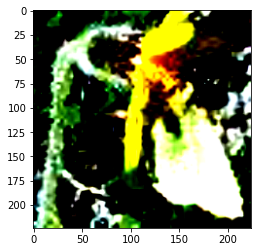

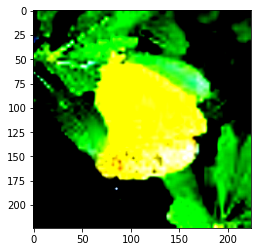

In [9]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

### Тренировочный класс lightning

In [7]:
class YourModule1(pl.LightningModule):
    def __init__(self, model, learning_rate) -> None:
        super().__init__()
        # YOUR CODE HERE
        self.model = model
        self.learning_rate = learning_rate
        self.model.heads = nn.Identity()
        self.classifier = nn.Linear(768, 200)
        self.optimizer = torch.optim.SGD(self.classifier.parameters(), momentum=0.9, lr = self.learning_rate)
        self.loss = nn.CrossEntropyLoss()
        pass

    def forward(self, x):
        # YOUR CODE HERE
        with torch.no_grad():
            features = self.model(x)
        preds = self.classifier(features)
        
        return preds
        pass

    def configure_optimizers(self):
        # YOUR CODE HERE
        return self.optimizer
        pass

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        # YOUR CODE HERE
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss
        pass

    def validation_step(self, val_batch, batch_idx) -> None:
        # YOUR CODE HERE
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)
        return acc
        pass

In [8]:
wandb_logger = WandbLogger(log_model='all') # какие возможности дает с pytorch_lightning https://docs.wandb.ai/guides/integrations/lightning
checkpoint_callback = ModelCheckpoint(monitor="accuracy", mode="max")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vit_b_16(pretrained=True) # YOUR CODE HERE
module = YourModule1(model, 0.001) # YOUR CODE HERE

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:388: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Wei

In [9]:
trainer = pl.Trainer(
      logger=wandb_logger,
      accelerator="gpu",
      max_epochs=1,
      callbacks=[checkpoint_callback]
)  # YOUR CODE HERE

trainer.fit(module, train_dataloader, val_dataloader)  # YOUR CODE HERE

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type              | Params
-------------------------------------------------
0 | model      | VisionTransformer | 85.8 M
1 | classifier | Linear            | 153 K 
2 | loss       | CrossEntropyLoss  | 0     
-------------------------------------------------
86.0 M    Trainable params
0         Non-trainable params
86.0 M    Total params
343.810   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


### Валидация результатов задания

In [12]:
from pytorch_lightning.core.hooks import ModelHooks
from pytorch_lightning.core.saving import ModelIO
def evaluate_task1(model, test_dataloader):
    from torchmetrics.functional import accuracy
    model = model.to(device)
    model.eval()
    acc = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            preds = torch.Tensor().to(device)
            output = model(images)
            pred = torch.argmax(output, dim=-1)
            preds = torch.cat((preds, pred.cuda()), 0)
            acc_batch = accuracy(preds.long(), labels.long())
            
        acc += acc_batch
    accuracy = acc / len(test_dataloader)
    print(accuracy)
    return accuracy

# Эксперимент 1

Model Resnet18, 256 bs, Adam, lr=0.001, 1 epoch

Строка кода и вандб не сохранился((((, accuracy был 0,46

# Эксперимент 2

Model-Vit_b_16, 256 bs, Adam, lr=0.0009, 1 epochs

In [15]:
#wandb.save('model.n1')
torch.save(module, '/content/module')
saved_module = torch.load('/content/module')

In [16]:
accuracy = evaluate_task1(saved_module, val_dataloader)
print(accuracy)
print(f"Оценка за это задание составит {10 * (accuracy - 0.5) / 0.34} баллов")

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 40/40 [01:49<00:00,  2.74s/it]

tensor(0.8317, device='cuda:0')
tensor(0.8317, device='cuda:0')
Оценка за это задание составит 9.75700855255127 баллов


# Эксперимент 3

Model-Vit_b_16, 256 bs, Adam, lr=0.0013, 2 epochs

In [11]:
torch.save(module, '/content/module2')
saved_module = torch.load('/content/module2')

In [12]:
accuracy = evaluate_task1(saved_module, val_dataloader)
print(accuracy)
print(f"Оценка за это задание составит {10 * (accuracy - 0.5) / 0.34} баллов")

100%|██████████| 40/40 [01:48<00:00,  2.72s/it]

tensor(0.8363, device='cuda:0')
tensor(0.8363, device='cuda:0')
Оценка за это задание составит 9.892004013061523 баллов


# Эксперимент 4

Model Vit_b_16, 256 bs, SGD, lr=0.001, 1 epoch

In [10]:
torch.save(module, '/content/sgd')
saved_module = torch.load('/content/sgd')

In [13]:
accuracy = evaluate_task1(saved_module, val_dataloader)
print(accuracy)
print(f"Оценка за это задание составит {10 * (accuracy - 0.5) / 0.34} баллов")

100%|██████████| 40/40 [01:53<00:00,  2.85s/it]

tensor(0.6231, device='cuda:0')
tensor(0.6231, device='cuda:0')
Оценка за это задание составит 3.621898889541626 баллов


# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

https://wandb.ai/nikoz/lightning_logs/reports/Task-1-Report--VmlldzoyODkyMTU5?accessToken=1a48n5rehozaxp5zvemy1p00tkofciiy4mz5kars5ogz8hhu4a5v5rru72p2khit - отчет по первому заданию

https://wandb.ai/nikoz/Task%202/reports/Task-2-Report--VmlldzoyODkyMDc2?accessToken=n69dvm3q4a0w43pp6ei2opp707bnxhw7smwtp89tcv5e9rt4o4pt3g594dhj55kv - отчет по второму заданию